# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Detect environment

In [2]:
from pkg.marker_config import *
from pkg.environment_builder import *
from pkg.geometry import *
from pkg.utils import *

init_stereo()
aruco_map, dictionary = get_aruco_config()

ROBOTS_ON_SCENE = [("indy0", RobotType.indy7_robot), ("panda1", RobotType.panda_robot)]
JOINT_NAMES_DEFINED = ['indy0_joint0', 'indy0_joint1', 'indy0_joint2', 'indy0_joint3', 'indy0_joint4', 'indy0_joint5',
                   'panda1_joint1', 'panda1_joint2', 'panda1_joint3', 'panda1_joint4', 
                   'panda1_joint5', 'panda1_joint6', 'panda1_joint7']
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,np.pi/2])

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
xyz_rpy_robots, xyz_rvec_cams, env_gen_dict, objectPose_dict, corner_dict, color_image  = \
    detect_environment(
        aruco_map, dictionary, robot_tuples=ROBOTS_ON_SCENE,
        env_dict={'floor': CallHolder(GeoBox, ["center", "orientation"], BLH=(1.52,0.72,0.01)),
                  'wall':CallHolder(GeoBox, ["center", "orientation"], BLH=(3,3,0.01))},
        camT_dict={"cam0":np.identity(4), "cam1": T_c12},
        ref_name='floor')

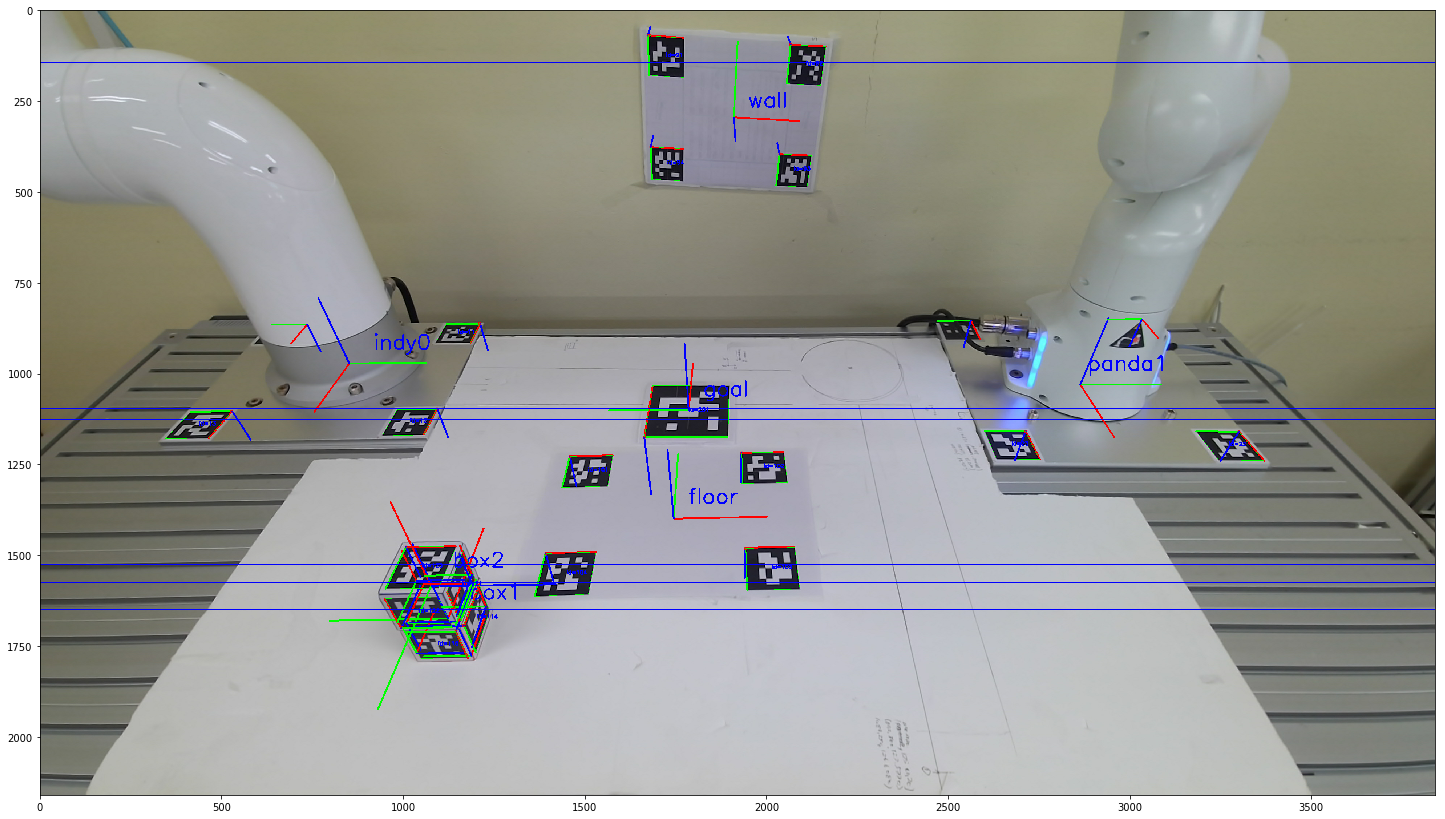

In [4]:
plt.figure(figsize=(25,15))
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

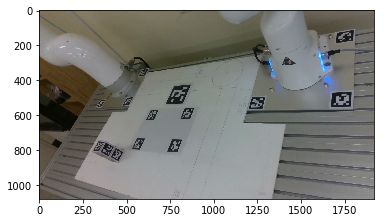

In [5]:
plt.imshow(get_rs_image()[:,:,[2,1,0]])

In [6]:
# with open('config.pkl', 'wb') as f:
#     pickle.dump({"objectPose_dict":objectPose_dict, "corner_dict":corner_dict}, f)

In [7]:
# disconnRobotType.indy7_robotect_stereo()

# Define robot config

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer(ROBOTS_ON_SCENE, xyz_rpy_robots)

vel_scale, acc_scale = 0.5, 0.5
custom_limits = {}
XacroCustomizer.update_limit_dict(custom_limits, "vel", JOINT_NAMES_DEFINED, 
                                  vel_scale * np.deg2rad(
        [150, 150, 150, 180, 180, 180, 150, 150, 150, 150, 180, 180, 180]))
XacroCustomizer.update_limit_dict(custom_limits, "acc", JOINT_NAMES_DEFINED, 
                                  acc_scale * np.deg2rad(
        [360]*len(JOINT_NAMES_DEFINED)))
custom_limits['panda1_joint1']['lower'], custom_limits['panda1_joint1']['upper'] = -2.75, 2.75
custom_limits['panda1_joint2']['lower'], custom_limits['panda1_joint2']['upper'] = -1.70, 1.70
custom_limits['panda1_joint3']['lower'], custom_limits['panda1_joint3']['upper'] = -2.75, 2.75
custom_limits['panda1_joint4']['lower'], custom_limits['panda1_joint4']['upper'] = -2.9, -0.1
custom_limits['panda1_joint5']['lower'], custom_limits['panda1_joint5']['upper'] = -2.75, 2.75
custom_limits['panda1_joint6']['lower'], custom_limits['panda1_joint6']['upper'] = 0.1, 3.6
custom_limits['panda1_joint7']['lower'], custom_limits['panda1_joint7']['upper'] = -2.75, 2.75


JOINT_NAMES, LINK_NAMES, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={},
        joint_limit_dict=custom_limits)
refine_meshes()
xcustom.start_rviz()

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


# Create Graph

In [9]:
from pkg.constraint_graph import *
from pkg.constants import *
from pkg.plot_utils import *
from pkg.utils import *

rospy.init_node('task_planner', anonymous=True)

In [10]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = True, connect_indy = True)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

add_cam_poles(graph, xyz_rvec_cams)
add_objects_gen(graph, env_gen_dict)

if graph.connect_indy:
    graph.indy.connect_and(graph.indy.joint_move_to,np.rad2deg(ZERO_JOINT_POSE[graph.indy_idx]))
if graph.connect_panda:
    graph.panda.move_joint_interpolated(ZERO_JOINT_POSE[graph.panda_idx], N_div=300)
    graph.panda.set_k_gain(70)
    graph.panda.set_d_gain(7)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


## add custom meshes

In [11]:
graph.add_geometry_items([
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm2_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi*2/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox((0, 0,0.0675), (0.05,0.05,0.130), orientation=(0,0,0), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.3), collision=True),
                           GeoSegment((-0.1,0,0.03), (0,np.pi/2,0), 0.2, 0.05, name="indy0_plug", link_name="indy0_link0",
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True),
                           GeoSegment((-0.05,0,0.03), (np.pi/2,0.0,0.0), 0.3, 0.05, name="cableset", link_name="panda1_link0", 
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True)
    ], fixed=True)

In [63]:
graph.get_object_by_name('grip1')

## Register binders

In [12]:
graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,112e-3], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=(0, 0,0.132), link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

# Add objects

In [13]:
MOVABLE_GENERATORS = {'box1': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.8,0.3,0.3,1)), 
                 'box2': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.3,0.3,0.8,1)), 
                 'box3': CallHolder(GeoSphere, ["center", None], radius=0.15, color=(0.8,0.8,0.0,0.3), collision=False), 
                 'goal': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.1, 0.1,0.01), color=(0.8,0.0,0.0,1))}
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.008], direction=[0,0,1])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True)}

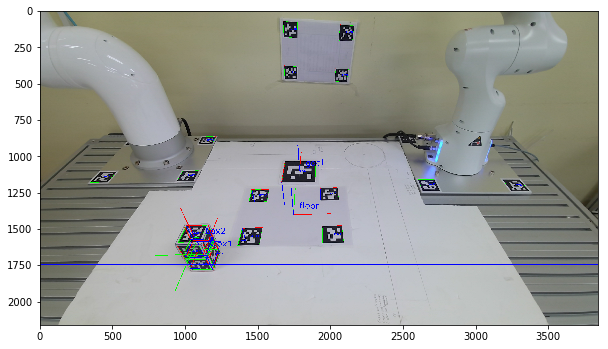

In [14]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
put_point_dict = register_objects(graph, objectPose_dict_mv, MOVABLE_GENERATORS, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=("floor", objectPose_dict["floor"]), link_name="world")

plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

# Set RVIZ

In [15]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)
    

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Connect: Server IP (192.168.0.63)


# Search Graph (Custom Robots)

In [16]:
graph.build_graph()

In [17]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
    objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
graph.show_pose(ZERO_JOINT_POSE)

In [18]:
dt_sim = 0.04
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))

goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
# goal_nodes = goal_nodes[3:4]

graph.search_graph_mp(
    initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
    tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
print(gtimer)

Connect: Server IP (192.168.0.63)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.67 s, steps/err: 45(311.339139938 ms)/0.298575721293)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.76 s, steps/err: 65(386.272907257 ms)/0.300503656227)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.92 s, steps/err: 50(438.300848007 ms)/0.48287582361)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.94 s, steps/err: 92(637.681007385 ms)/0.536816735789)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'top_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fai

In [19]:
print(graph.search_counter.value)
print(gtimer)

18
search_graph_mp: 	2825.0 ms/1 = 2825.443 ms (2825.443/2825.443)
init_search: 	168.0 ms/1 = 168.404 ms (168.404/168.404)
score_graph: 	86.0 ms/8 = 10.794 ms (9.35/13.732)
reset_valid_node: 	49.0 ms/18597 = 0.003 ms (0.001/0.118)
check_goal: 	13.0 ms/18601 = 0.001 ms (0.0/0.023)
get_valid_neighbor: 	8.0 ms/498 = 0.017 ms (0.005/0.079)
add_node_queue_leafs: 	108.0 ms/1 = 107.722 ms (107.722/107.722)
find_schedules: 	1.0 ms/1 = 0.906 ms (0.906/0.906)
sort_schedule: 	0.0 ms/1 = 0.006 ms (0.006/0.006)



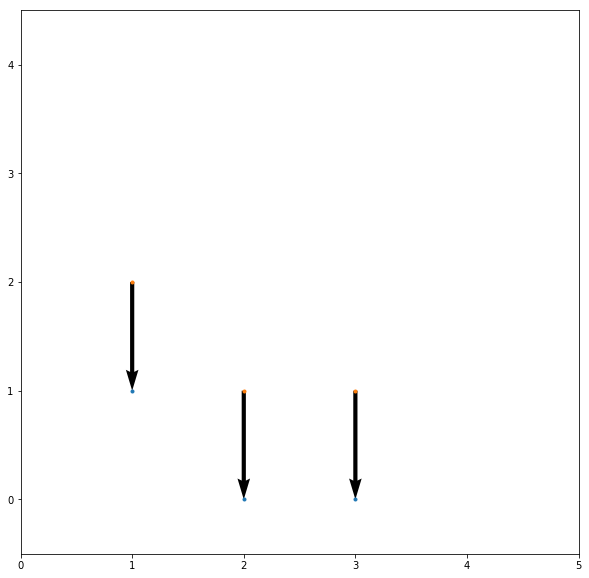

In [20]:
graph.quiver_snodes()

# Replay schedule

In [48]:
N_fullstep = 500
dt_vis = 0.01
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted[:], range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_vis, N_step=N_fullstep, 
                     vel_conv=1e-2, err_conv=1e-3, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 1, 2]
[0, 1, 3]

--------------------
1-(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'floor'))

--------------------
2-(('box1', 'bottom_p', 'goal_bd'), ('box2', 'left_p', 'floor'))

--------------------
1-(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'floor'))

--------------------
3-(('box1', 'left_p', 'goal_bd'), ('box2', 'left_p', 'floor'))


In [51]:
print(full_context)


require("context")
require("geometric")
--require("libexpressiongraph_collision")
require("collision")
require("libexpressiongraph_velocities")
local u=UrdfExpr(0.25);
local fn = "/home/junsu/Projects/tf_gmt/eTaSL/robots/custom_robots.urdf"
u:readFromFile(fn)

margin=0.0001
radius=0.0
error_target=0
u:addTransform("T_world","world","world")
u:addTransform("T_indy0_link0","indy0_link0","world")
u:addTransform("T_indy0_link1","indy0_link1","world")
u:addTransform("T_indy0_link2","indy0_link2","world")
u:addTransform("T_indy0_link3","indy0_link3","world")
u:addTransform("T_indy0_link4","indy0_link4","world")
u:addTransform("T_indy0_link5","indy0_link5","world")
u:addTransform("T_indy0_link6","indy0_link6","world")
u:addTransform("T_indy0_tcp","indy0_tcp","world")
u:addTransform("T_panda1_link0","panda1_link0","world")
u:addTransform("T_panda1_link1","panda1_link1","world")
u:addTransform("T_panda1_link2","panda1_link2","world")
u:addTransform("T_panda1_link3","panda1_link3","world")
u:ad

# Execute traj online

In [22]:
schedule = schedule_sorted[0]
state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
obs_names = ["box3"]

with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
        RvizPublisher(graph, obs_names) as rviz_pub:
    graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=False, 
                                  obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


# onestep

In [36]:
def loop_process():
    loop_process.stop_now = False
    while not loop_process.stop_now:
        print("wait for button input")
        graph.indy.connect_and(graph.indy.wait_di, 16)
        if loop_process.stop_now:
            break
        kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
        objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
            detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
        objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
        xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
            objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
        update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
        graph.show_pose(ZERO_JOINT_POSE)
        
        dt_sim = 0.04
        T_step = 10
        N_fullstep = int(T_step / dt_sim)
        gtimer.reset()
        initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))

        goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
        # goal_nodes = goal_nodes[3:4]

        graph.search_graph_mp(
            initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
            tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
            terminate_on_first = True, N_search = 100, N_loop=1000,
            display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
            **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)
        print(gtimer)
        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)

        schedule = schedule_sorted[0]
        state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
        obs_names = ["box3"]

        with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
                RvizPublisher(graph, obs_names) as rviz_pub:
            graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                          vel_conv=0.2e-2, err_conv=1e-3, T_step = 50, on_rviz=False, 
                                          obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
    print("===========================================")
    print("=================KILLED====================")
    print("===========================================")
t_loop = Thread(target=loop_process)
t_loop.start()

wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.65 s, steps/err: 77(437.759160995 ms)/0.280155577637)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.73 s, steps/err: 64(436.12909317 ms)/0.612670516865)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.09 s, steps/err: 86(687.210083008 ms)/0.965635037362)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.35 s, steps/err: 40(611.390113831 ms)/0.497847979587)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.36 s, steps/er


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (4.06 s, steps/err: 182(1485.28909683 ms)/0.417024671282)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (4.29 s, steps/err: 86(645.097017288 ms)/0.621868361733)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (4.42 s, steps/err: 156(1148.06294441 ms)/0.389530551292)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (4.42 s, steps/err: 250(1751.50513649 ms)/0.446294910596)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (4.45 s, steps/err: 67(571.280002594 ms)/0.817591886789)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'right_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (7.15 s, steps/err: 103(1233.44802856 ms)/0.659269591323)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'back_p', 'vac2'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (7.19 s, steps/err: 122(1142.37380028 ms)/0.344598571606)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (7.7 s, steps/err: 230(1200.50501823 ms)/0.203458836687)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (7.95 s, steps/err: 222(1657.3741436 ms)/0.273852139862)
fail - Goal cost:2->1 / Init cost:0-

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (9.94 s, steps/err: 50(616.814136505 ms)/0.988259281572)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.12 s, steps/err: 35(434.885025024 ms)/0.851534528741)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.16 s, steps/err: 153(1060.76002121 ms)/0.427482826238)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'right_p', 'gri


fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (12.04 s, steps/err: 37(423.398971558 ms)/0.157885605966)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (12.3 s, steps/err: 77(532.795906067 ms)/0.428045631856)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (12.45 s, steps/err: 37(544.507980347 ms)/0.689846485564)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (12.51 s, steps/err: 120(699.973106384 ms)/0.471784494656)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / In


fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (15.3 s, steps/err: 159(1077.37112045 ms)/0.505994367345)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (15.34 s, steps/err: 63(655.451059341 ms)/0.560805643923)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (15.38 s, steps/err: 250(1252.6371479 ms)/0.0565853775394)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'top_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (15.62 s, steps/err: 87(651.173114777 ms)/0.600094796471)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cos


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (18.08 s, steps/err: 186(1414.01386261 ms)/0.937967854187)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (18.22 s, steps/err: 94(523.618936539 ms)/0.279875088597)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (18.34 s, steps/err: 40(333.530902863 ms)/1.08847386256)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (18.69 s, steps/err: 79(525.154829025 ms)/0.663063331239)
node: (('box1', 'bottom_p', '

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (20.84 s, steps/err: 248(1253.10707092 ms)/0.121076032006)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (20.95 s, steps/err: 72(655.101060867 ms)/0.490236144913)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (20.96 s, steps/err: 141(1171.78201675 ms)/0.419409034647)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'back_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (21.06 s, steps/err: 88(662.183046341 ms)/0.373100270602)
node: (('box1', 'bottom_p', 'fl


fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (23.85 s, steps/err: 40(651.367902756 ms)/0.820732135363)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (23.92 s, steps/err: 250(2210.4279995 ms)/0.266547933383)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (23.93 s, steps/err: 41(545.492172241 ms)/1.21026161196)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (23.95 s, steps/err: 35(602.541923523 ms)/1.17771519024)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost


fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (26.04 s, steps/err: 250(1611.28306389 ms)/0.102229552133)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (26.38 s, steps/err: 35(381.765127182 ms)/1.13837455078)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (26.43 s, steps/err: 227(2377.73418427 ms)/0.260668938586)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'top_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (26.89 s, steps/err: 187(1468.15800667 ms)/0.203054581418)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (26.9 s, steps/err: 82(814.370155334 ms)/0.656674023629)
node: (('box1', 'bottom_p', 'floor'), ('box2', '


fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (28.91 s, steps/err: 117(805.689096451 ms)/1.00486645132)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (29.14 s, steps/err: 51(740.769147873 ms)/0.601779948428)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (29.23 s, steps/err: 63(836.457967758 ms)/0.349230274389)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (29.41 s, steps/err: 222(1170.96614838 ms)/0.134037585077)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (29.43 s, steps/err: 35(531.539916992 ms)/0.164075113431)node: (('box1', 'bottom_p', 'floor'), ('box2

unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (31.62 s, steps/err: 250(433.58707428 ms)/1.07283963389)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (31.76 s, steps/err: 89(751.813173294 ms)/1.02959855612)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (31.86 s, steps/err: 53(469.121932983 ms)/1.1971734059)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (31.87 s, steps/err: 250(2103.85799408 ms)/0.400390948214)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'top_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'),

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (33.72 s, steps/err: 39(528.692960739 ms)/1.26198267047)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (33.87 s, steps/err: 89(815.065860748 ms)/0.476803283739)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (33.9 s, steps/err: 250(1959.88607407 ms)/0.273423900421)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'top_p', 'vac2'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (34.06 s, steps/err: 89(625.674962997 ms)/0.691289326219)
node: (('box1', 'bottom_p', 'floor'), (


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (36.07 s, steps/err: 39(449.193000793 ms)/0.528447414944)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (36.13 s, steps/err: 241(1897.15600014 ms)/0.289847637268)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (36.28 s, steps/err: 250(1214.48493004 ms)/0.144770207768)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'left_p', 'fl

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (39.02 s, steps/err: 45(565.0639534 ms)/0.748573434735)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (39.19 s, steps/err: 250(2263.76795769 ms)/0.213186192961)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (39.27 s, steps/err: 69(648.927927017 ms)/0.55510388644)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (39.35 s, steps/err: 98(904.896020889 ms)/0.371582516579)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (41.68 s, steps/err: 92(886.41500473 ms)/1.07409539965)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (41.76 s, steps/err: 36(528.439044952 ms)/0.79377020325)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (42.14 s, steps/err: 47(366.066932678 ms)/1.11224819086)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (42.15 s, steps/err: 177(1142.41600037 ms)/0.600736016723)=======


fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (44.49 s, steps/err: 95(763.160943985 ms)/0.497821366657)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (44.59 s, steps/err: 250(1780.20000458 ms)/0.393464740926)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (44.64 s, steps/err: 34(471.07219696 ms)/1.17957839282)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'front_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 4-> (44.75 s, steps/err: 63(512.610912323 ms)/0.6380776728)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (47.34 s, steps/err: 119(1145.98083496 ms)/0.479649281178)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (47.37 s, steps/err: 75(760.64991951 ms)/0.538039891946)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (47.47 s, steps/err: 140(1427.97493935 ms)/0.34852160273)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (47.52 s, steps/err: 43(515.712976456 ms)/0.515852940225)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost



fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (49.8 s, steps/err: 37(581.832885742 ms)/0.536299229121)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'right_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (49.92 s, steps/err: 58(506.83093071 ms)/0.498492008809)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (49.98 s, steps/err: 132(956.250190735 ms)/0.0723454087664)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (50.19 s, steps/err: 81(864.261865616 ms)/0.503695222469)
node: (('box1', 'bottom_p', 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (52.84 s, steps/err: 82(812.555789948 ms)/0.559420957825)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (53.01 s, steps/err: 120(782.171010971 ms)/0.179206590084)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (53.31 s, steps/err: 162(1103.82699966 ms)/0.363530691771)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (53.41 s, steps/err: 214(2021.77381516 ms)/0.377010004972)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 3-> (53.44 s, steps/err: 68(518.445968628 ms)/0.542227535065)

node: (('box1', 'bottom_p', 'floor'), (


fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (55.27 s, steps/err: 87(827.23402977 ms)/0.328969754153)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (55.45 s, steps/err: 107(973.474979401 ms)/0.358848636992)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (55.84 s, steps/err: 84(719.194173813 ms)/0.520635321829)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (55.91 s, steps/err: 95(564.520835876 ms)/0.749316953718)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (58.09 s, steps/err: 110(669.483184814 ms)/0.157896382864)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'left_p', 'floor'))
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (58.61 s, steps/err: 250(395.744085312 ms)/0.721914909167)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (58.62 s, steps/err: 72(773.531913757 ms)/0.598067467119)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'right_p', 'vac2'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (58.83 s, steps/err: 99(1027

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (60.97 s, steps/err: 143(1266.97397232 ms)/0.420659639514)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (60.97 s, steps/err: 172(1306.53190613 ms)/0.77978766816)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'back_p', 'vac2'))


fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (61.01 s, steps/err: 86(587.767124176 ms)/0.467894032464)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (61.03 s, steps/err: 51(583.372116089 ms)/0.735935055778)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

node:


fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (63.35 s, steps/err: 250(2053.358078 ms)/0.0969779766535)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (63.39 s, steps/err: 87(653.943061829 ms)/0.316174003938)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'right_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'front_p', 'vac2'))
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (63.63 s, steps/err: 250(287.198066711 ms)/0.727676382028)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (63.69 s, steps/err: 72(478.850126266 ms)/0.605064965591)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 6-> (63.72 s, steps/err: 164(1088.20486069



node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (65.6 s, steps/err: 64(682.777881622 ms)/0.483650193553)unknown eTaSL exception: optimization failed during execution

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (65.64 s, steps/err: 250(377.449035645 ms)/0.849336505941)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branc

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (67.93 s, steps/err: 250(505.291223526 ms)/0.883072459271)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (68.01 s, steps/err: 91(835.500001907 ms)/0.679185820019)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (68.12 s, steps/err: 186(1016.44897461 ms)/0.265022065324)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (68.59 s, steps/err: 104(768.37015152 ms)/0.593427379446)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cos


fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (71.02 s, steps/err: 89(729.207038879 ms)/1.04109336213)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (71.03 s, steps/err: 157(933.445215225 ms)/0.0944406288616)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (71.03 s, steps/err: 250(1522.34315872 ms)/0.0692411585392)


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'left_p', 'floor'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (71.22 s, steps/err: 250(1876.78313255 ms)/0.273809430336)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / I

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (73.93 s, steps/err: 250(1867.48695374 ms)/0.379620842397)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (73.98 s, steps/err: 48(433.617115021 ms)/0.391799270666)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (74.13 s, steps/err: 69(592.055082321 ms)/0.998595931457)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 5-> (74.21 s, steps/err: 164(1282.71794319 ms)/0.604499178592)
node: (('box1', 'bottom_p', 'floor'


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (76.51 s, steps/err: 220(1519.17600632 ms)/0.313262543351)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (76.64 s, steps/err: 132(1435.93215942 ms)/0.630730517694)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (76.66 s, steps/err: 93(645.195007324 ms)/0.270831522048)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'front_p', 'vac2'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (76.76 s, steps/err: 68(471.724033356 ms)/1.28384557123)
node: (('box1', 'bottom_p', '



fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (78.6 s, steps/err: 250(1614.02201653 ms)/0.504858685711)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'right_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (78.85 s, steps/err: 57(416.177988052 ms)/0.600043135947)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (78.93 s, steps/err: 75(539.316892624 ms)/1.05331681716)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (78.98 s, steps/err: 109(667.453050613 ms)/0.536659087281)===================================


fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (81.12 s, steps/err: 89(726.608991623 ms)/0.499642852348)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'top_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (81.23 s, steps/err: 250(1808.06207657 ms)/0.216248700582)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (81.28 s, steps/err: 250(1261.03997231 ms)/0.0969890422168)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'back_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (81.43 s, steps/err: 77(509.871959686 ms)/1.21091419979)
node: (('box1', 'bottom_p', 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (83.85 s, steps/err: 140(955.744981766 ms)/0.918211491756)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (83.97 s, steps/err: 84(731.687068939 ms)/0.634776677017)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (83.98 s, steps/err: 65(445.353031158 ms)/0.743767962401)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'top_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (84.33 s, steps/err: 151(957.485198975 ms)/0.375779746699)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Ini


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 8-> (86.61 s, steps/err: 199(1448.61602783 ms)/0.261685138151)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (86.89 s, steps/err: 58(596.97508812 ms)/0.617671435979)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (86.9 s, steps/err: 41(324.291944504 ms)/0.710495189164)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'top_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (87.07 s, steps/err: 250(1829.6380043 ms)/0.346971274639)
node: (('box1', 'bottom_p', 'floor


fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (88.79 s, steps/err: 250(1649.19400215 ms)/0.131662609914)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (88.94 s, steps/err: 60(477.072000504 ms)/0.404796462172)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (89.22 s, steps/err: 124(793.731927872 ms)/0.548711093965)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (89.29 s, steps/err: 83(734.742879868 ms)/0.501265936297)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init c


fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (91.46 s, steps/err: 250(1790.66514969 ms)/0.210966483596)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (91.53 s, steps/err: 198(1078.7088871 ms)/0.094891477995)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (91.58 s, steps/err: 164(1234.62200165 ms)/0.0954984243494)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (93.61 s, steps/err: 29(399.111032486 ms)/0.886880453298)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (93.64 s, steps/err: 250(1198.14109802 ms)/0.15435146955)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (93.79 s, steps/err: 64(562.896966934 ms)/0.367299142187)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'front_p', 'vac2'))
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (94.0 s, steps/err: 71(556.419849396 ms)/0.843077406337)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 7-> (94.0 s, steps/err: 250(303.363800049 ms)/


fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (96.0 s, steps/err: 87(822.225093842 ms)/0.36699822786)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (96.03 s, steps/err: 64(490.370988846 ms)/0.490731920227)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'right_p', 'vac2'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (96.07 s, steps/err: 53(586.495876312 ms)/0.499656092141)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (96.19 s, steps/err: 104(782.341957092 ms)/0.440098362128)
node


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (98.42 s, steps/err: 111(805.061101913 ms)/0.689056659139)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (98.56 s, steps/err: 134(965.125799179 ms)/0.541784674763)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (98.96 s, steps/err: 213(1501.82986259 ms)/0.274423616648)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (99.02 s, steps/err: 30(386.611938477 ms)/0.533455426559)===========================


fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (101.12 s, steps/err: 250(1714.53380585 ms)/0.0989363827598)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (101.15 s, steps/err: 95(736.20390892 ms)/1.22761142998)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'left_p', 'floor'))


fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (101.21 s, steps/err: 89(529.587030411 ms)/0.14690106706)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'front_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (101.26 s, steps/err: 107(879.89783287 ms)/0.536565278635)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Ini


fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (103.77 s, steps/err: 213(1582.55696297 ms)/0.592058863889)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (103.87 s, steps/err: 250(2334.24901962 ms)/0.199002456437)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (103.95 s, steps/err: 75(622.536182404 ms)/0.583607214501)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 9-> (104.03 s, steps/err: 156(1213.73200417 ms)/0.0999219403443)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / I


fail - Goal cost:2->1 / Init cost:1->1 / branching: 11-> (106.48 s, steps/err: 74(480.448007584 ms)/0.228983555661)
fail - Goal cost:2->1 / Init cost:1->1 / branching: 10-> (106.51 s, steps/err: 221(1478.28006744 ms)/0.0942984849991)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'bottom_p', 'vac2'))->(('box1', 'right_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'right_p', 'vac2'))->(('box1', 'left_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:1->1 / branching: 11-> (106.57 s, steps/err: 164(1348.29616547 ms)/0.186820475678)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'bottom_p', 'vac2'))->(('box1', 'back_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:1->1 / branching: 10-> (106.7 s, steps/err: 74(655.131816864 ms)/0.228983600222)

fail - Goal cost:2->1 / Init cost:1->1 / branching: 11-> (106.73 s, steps/err: 165(1031.38399124 ms)/0.103150811132)node: (('box1', 'bottom_p',

fail - Goal cost:2->1 / Init cost:1->1 / branching: 13-> (108.4 s, steps/err: 83(612.565994263 ms)/0.430174277056)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'bottom_p', 'vac2'))->(('box1', 'right_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:1->1 / branching: 14-> (108.49 s, steps/err: 127(1060.38403511 ms)/0.206164789753)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'right_p', 'vac2'))->(('box1', 'back_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:1->1 / branching: 12-> (108.69 s, steps/err: 71(372.071027756 ms)/0.430512589648)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'right_p', 'vac2'))->(('box1', 'right_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->2 / Init cost:0->0 / branching: 8-> (108.81 s, steps/err: 37(395.447969437 ms)/0.13558881826)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))

success - Goal cost:

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (111.43 s, steps/err: 250(1939.59212303 ms)/0.304206130834)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (111.45 s, steps/err: 250(1422.97697067 ms)/0.0854031137644)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'left_p', 'floor'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (111.5 s, steps/err: 147(1313.56692314 ms)/0.914034717041)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (111.57 s, steps/err: 250(1761.73710823 ms)/0.212912207486


fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (113.9 s, steps/err: 250(1833.74905586 ms)/0.261682768528)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (113.98 s, steps/err: 223(1474.70092773 ms)/0.268208968013)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (114.13 s, steps/err: 42(450.042963028 ms)/0.730481990041)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (114.33 s, steps/err: 81(611.754894257 ms)/0.488385082308)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (117.08 s, steps/err: 250(1962.16201782 ms)/0.359227674777)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (117.49 s, steps/err: 250(2116.16587639 ms)/0.23495503249)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (117.5 s, steps/err: 101(671.563148499 ms)/1.00348994519)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (117.63 s, steps/err: 250(1476.12285614 ms)/0.528630584461)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'top_p', 'vac2'))

fail - Goal cost:2->1 /


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (120.0 s, steps/err: 56(407.557010651 ms)/0.797997155533)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (120.07 s, steps/err: 75(586.266040802 ms)/0.50180912421)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (120.43 s, steps/err: 250(1353.4090519 ms)/0.160453542202)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (120.46 s, steps/err: 35(416.547060013 ms)/1.01240927858)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'left_p', 'floor'))


fail - Goal cost:2->1 / In


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (123.04 s, steps/err: 81(630.062103271 ms)/0.617302178818)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (123.16 s, steps/err: 58(431.755065918 ms)/1.32136966556)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (123.28 s, steps/err: 101(836.749076843 ms)/0.363792239713)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (123.24 s, steps/err: 250(2009.80496407 ms)/0.278317129489)========================


fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (125.24 s, steps/err: 197(1607.42592812 ms)/0.242967216933)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (125.35 s, steps/err: 156(1069.16189194 ms)/0.91340585051)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (125.42 s, steps/err: 145(1277.27198601 ms)/0.753574952847)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'top_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (125.48 s, steps/err: 58(553.70092392 ms)/0.501544138202)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->1 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (127.71 s, steps/err: 79(499.164819717 ms)/0.501880972291)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (127.93 s, steps/err: 143(1022.39322662 ms)/0.256490967073)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (128.09 s, steps/err: 250(1488.47699165 ms)/0.260805066183)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (128.13 s, steps/err: 72(401.080846786 ms)/0.381638636555)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'left_p', 'floor'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cos


success - Goal cost:2->2 / Init cost:0->0 / branching: 8->18 (130.28 s, steps/err: 27(294.962882996 ms)/0.000705779255144)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (130.29 s, steps/err: 54(525.743961334 ms)/0.302520694155)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (130.32 s, steps/err: 121(1049.077034 ms)/0.417974369828)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (130.45 s, steps/err: 53(582.796096802 ms)/0.652212175535)

success - Goal cost:2->2 / Init cost:0->0 / branching: 8->19 (130.49 s, steps/err: 20(428.263187408 ms)/0.000916137862653)node: (('box1', 'bottom


fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (132.85 s, steps/err: 250(1654.3879509 ms)/0.257229775028)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (132.94 s, steps/err: 126(1068.1450367 ms)/0.592743504494)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'front_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (133.23 s, steps/err: 88(717.352867126 ms)/0.0974974201098)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (133.25 s, steps/err: 198(1713.11998367 ms)/0.261525459276)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'floor'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'front_p', 'grip1'))
unknown eTaSL exception


fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (135.33 s, steps/err: 107(727.066040039 ms)/0.558770867495)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (135.46 s, steps/err: 78(659.106016159 ms)/0.531499184472)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'left_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (135.52 s, steps/err: 96(604.487895966 ms)/0.504682826977)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (135.71 s, steps/err: 135(981.729984283 ms)/0.35571944148)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (135.69 s, steps/err: 157(1287.56713867 ms)/0.503304519143)

fail - Goal cost:2->1 / Init co


fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (137.81 s, steps/err: 59(563.586950302 ms)/0.516195154248)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'grip1'), ('box2', 'right_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (137.91 s, steps/err: 80(603.455066681 ms)/0.38548940871)unknown eTaSL exception: optimization failed during execution

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'bottom_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (137.96 s, steps/err: 250(326.970100403 ms)/1.70981585883)======================================================================================================================================================

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'grip1'), ('box2', 'left_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (140.01 s, steps/err: 110(831.546068192 ms)/0.348314403942)
unknown eTaSL exception: optimization failed during execution
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (140.09 s, steps/err: 250(340.523958206 ms)/1.11627448458)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (140.35 s, steps/err: 45(451.809167862 ms)/0.7433166045)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (140.34 s, steps/err: 232(1464.73288536 ms)/0.430725120468)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'left_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'gr


fail - Goal cost:2->1 / Init cost:0->1 / branching: 19-> (142.68 s, steps/err: 250(1619.3318367 ms)/0.214390363755)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'back_p', 'vac2'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (142.75 s, steps/err: 66(537.235975266 ms)/0.733746252987)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 19-> (142.78 s, steps/err: 250(1787.08791733 ms)/0.42251556561)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'right_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (142.87 s, steps/err: 167(955.342054367 ms)/0.089791420617)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'grip1'), ('box2', 'left_p', 'floor'))

fail - Goal cost:2-


fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (145.12 s, steps/err: 184(1572.57509232 ms)/0.36218076249)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (145.28 s, steps/err: 95(769.212961197 ms)/0.55095901761)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'back_p', 'grip1'))

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (145.35 s, steps/err: 215(1535.14695168 ms)/0.354949072045)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (145.35 s, steps/err: 92(682.046890259 ms)/0.999819689145)

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'vac2'), ('box2', 'front_p', 'grip1'))
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'front_p', 'grip1'))

fail - Goal cost:2->

Process Process-26:
Traceback (most recent call last):



fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (147.46 s, steps/err: 215(1478.61886024 ms)/0.215126286679)

  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap



node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'right_p', 'vac2'), ('box2', 'back_p', 'grip1'))


    self.run()


  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-33:
    self._target(*self._args, **self._kwargs)
  File "pkg/utils.py", line 136, in __wrapper
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    res = func(*args, **kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "pkg/constraint_graph.py", line 791, in __search_loop
    while self.snode_counter.value < N_search and loop_counter < N_loop and not self.stop_now.value:
    self._target(*self._args, **self._kwargs)
  File "pkg/utils.py", line 136, in __wrapper
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 1039, in get
    res = func(*args, **kwargs)
    return self._callmethod('get')
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 759, in _callmethod
  File "pkg/constraint_graph.py", line 791, in __search_loop
    kind, result = conn.recv()
    while 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (147.83 s, steps/err: 190(910.976171494 ms)/0.369473700815)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (147.87 s, steps/err: 90(1142.46702194 ms)/0.283517068097)node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'right_p', 'vac2'))

node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'top_p', 'vac2'), ('box2', 'bottom_p', 'grip1'))


Process Process-30:


Traceback (most recent call last):



fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (147.9 s, steps/err: 250(1611.71507835 ms)/0.511773704558)

  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap


Process Process-32:
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'left_p', 'vac2'), ('box2', 'left_p', 'grip1'))


    self._target(*self._args, **self._kwargs)



fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (147.94 s, steps/err: 89(885.972976685 ms)/0.381528182002)======================================================================================================================================================


  File "pkg/utils.py", line 136, in __wrapper
    self.run()
Process Process-28:


  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    res = func(*args, **kwargs)
    self._target(*self._args, **self._kwargs)
  File "pkg/utils.py", line 136, in __wrapper
Traceback (most recent call last):
  File "pkg/constraint_graph.py", line 791, in __search_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap


node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'front_p', 'vac2'), ('box2', 'front_p', 'grip1'))


    res = func(*args, **kwargs)
    self.run()
    while self.snode_counter.value < N_search and loop_counter < N_loop and not self.stop_now.value:
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 1039, in get
  File "pkg/constraint_graph.py", line 791, in __search_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-27:
    return self._callmethod('get')
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 758, in _callmethod
    while self.snode_counter.value < N_search and loop_counter < N_loop and not self.stop_now.value:
    conn.send((self._id, methodname, args, kwds))
    self._target(*self._args, **self._kwargs)
  File "pkg/utils.py", line 136, in __wrapper
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    res = func(*args, **kwargs)
IOError: [Errno 32] Broken pipe
    self.run()
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 1039, i


fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (148.15 s, steps/err: 203(1335.698843 ms)/0.319781334911)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'back_p', 'vac2'), ('box2', 'front_p', 'grip1'))


Process Process-29:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "pkg/utils.py", line 136, in __wrapper
    res = func(*args, **kwargs)
  File "pkg/constraint_graph.py", line 791, in __search_loop
    while self.snode_counter.value < N_search and loop_counter < N_loop and not self.stop_now.value:
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 1039, in get
    return self._callmethod('get')
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 758, in _callmethod
    conn.send((self._id, methodname, args, kwds))
IOError: [Errno 32] Broken pipe



fail - Goal cost:2->1 / Init cost:0->1 / branching: 18-> (148.4 s, steps/err: 234(1451.73597336 ms)/0.510053388978)
node: (('box1', 'bottom_p', 'floor'), ('box2', 'left_p', 'floor'))->(('box1', 'bottom_p', 'grip1'), ('box2', 'front_p', 'vac2'))


Process Process-31:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "pkg/utils.py", line 136, in __wrapper
    res = func(*args, **kwargs)
  File "pkg/constraint_graph.py", line 791, in __search_loop
    while self.snode_counter.value < N_search and loop_counter < N_loop and not self.stop_now.value:
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 1039, in get
    return self._callmethod('get')
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 758, in _callmethod
    conn.send((self._id, methodname, args, kwds))
IOError: [Errno 32] Broken pipe


In [37]:
1

1

In [34]:
loop_process.stop_now=True

=================KILLED====================


In [35]:
t_loop.is_alive()

False

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Going back

In [133]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [35]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [38]:
self.reset_panda()

# test mesh

In [16]:
from pkg.gjk import *

In [21]:
Q1 = ZERO_JOINT_POSE
Q2 = ZERO_JOINT_POSE - 0.1

gtimer.reset()

gtimer.tic("svt")
swept_volume_test(Q1, Q2, graph.fixed_collision_items_list+graph.movable_collision_items_list, 
                  graph.joint_names, graph.urdf_content)
gtimer.toc("svt")

17.860889434814453

panda1_rightfinger_Mesh_0
pole_cam1


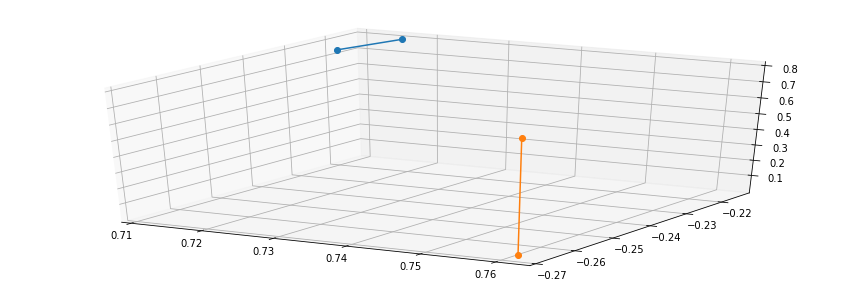

In [130]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))

idx_col = 205

sub = fig.add_subplot(1, 1, 1, projection="3d")
x, y, z = np.transpose(vtx2_list[idx1_list[idx_col]])
sub.plot(x, y, z, '-o')
x, y, z = np.transpose(vtx2_list[idx2_list[idx_col]])
print(GeometryItem.GLOBAL_GEO_LIST[idx1_list[idx_col]].name)
print(GeometryItem.GLOBAL_GEO_LIST[idx2_list[idx_col]].name)
sub.plot(x, y, z, '-o')
# sub.view_init(0, 90)

In [25]:
# np.save("vtx_list", vtx_list)
# np.save("radius_list", radius_list)
# np.save("idx1_list", idx1_list)
# np.save("idx2_list", idx2_list)

# test time

In [23]:
gtimer.reset()
found_vec = []
for _ in range(10):
    objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
        detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
    objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
    xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
        objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
    update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
    graph.show_pose(ZERO_JOINT_POSE)
    
    dt_sim = 0.04
    T_step = 10
    N_fullstep = int(T_step / dt_sim)
    initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))

    goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
    # goal_nodes = goal_nodes[3:4]

    graph.search_graph_mp(
        initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=True,
        tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
        **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)
    found_vec.append(len(schedule_sorted)>0)
print(gtimer)


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.1 s, steps/err: 250(1000.82087517 ms)/0.118931974288)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.15 s, steps/err: 250(1110.14890671 ms)/0.572747027797)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.31 s, steps/err: 250(1170.57013512 ms)/0.255064965093)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.37 s, steps/err: 250(1222.55396843 ms)/0.335583394457)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.43 s, steps/err: 250(1372.00188637 ms)/0.264198532646)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.01 s, steps/err: 250(1274.12700653 ms)/0.0325991536716)===== cut by swept volume test =====


fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.04 s, steps/err: 250(1142.34304428 ms)/0.138861874778)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)


fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.05 s, steps/err: nan(103.461027145 ms)/nan)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.07 s, steps/err: 250(1319.00119781 ms)/0.377650917112)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.07 s, steps/err: 250(1229.81286049 ms)/0.249519021404)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)


node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 1->5 (3.1 s, steps/err: 25(358.641147614 ms)/0.0008851151

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.72 s, steps/err: 250(1501.99890137 ms)/0.298842026036)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (1.87 s, steps/err: nan(96.0459709167 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.03 s, steps/err: nan(87.7258777618 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.07 s, steps/err: 250(1307.56998062 ms)/0.0637795853392)=============================================================================================================================================

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.35 s, steps/err: nan(88.4380340576 ms)/nan)===== cut by swept volume test =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.4 s, steps/err: nan(99.133014679 ms)/nan)===== cut by swept volume test =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.42 s, steps/err: nan(114.203214645 ms)/nan)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.44 s, steps/err: 250(1072.83306122 ms)/0.0833587008642)======================================================================================================================================================


fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.44 s, steps/err: nan(68.3579444885 ms)/nan)node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)
nod


fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.06 s, steps/err: 250(1468.8949585 ms)/0.252214559158)======================================================================================================================================================

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (5.4 s, steps/err: 250(1703.19199562 ms)/0.327042422697)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.53 s, steps/err: 250(2051.46384239 ms)/0.168655449131)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (5.72 s, steps/err: 250(246.978998184 ms)/1.00317159237)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'left_p', 'goal_bd'),)
unknown eTaSL exception: optimization fail

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 3->9 (8.32 s, steps/err: 3(249.050140381 ms)/0.00093800215154)======================================================================================================================================================

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (8.57 s, steps/err: 250(1140.52915573 ms)/0.247449012585)
unknown eTaSL exception: optimization failed during execution
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (8.61 s, steps/err: 250(297.981023788 ms)/0.389189960612)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (9.46 s, steps/err: 250(1

===== terminate =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (11.37 s, steps/err: 250(1190.16695023 ms)/0.492559053397)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
===== terminate =====

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.44 s, steps/err: 66(330.087900162 ms)/0.00080156023875)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.11 s, steps/err: 250(1079.16402817 ms)/0.272924902386)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.24 s, steps/err: 250(1062.50810623 ms)/0.361908521627)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.24 s, steps/err: 250(1187.73412704 ms)/0.37785471045)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init c


fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.54 s, steps/err: 250(1040.50087929 ms)/0.484772409357)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.57 s, steps/err: 250(1072.97611237 ms)/0.0735977697013)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.06 s, steps/err: 250(1408.83088112 ms)/0.0717858405763)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.09 s, steps/err: 250(1564.59116936 ms)/0.250316227315)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.25 s, steps/err: 250(1629.93192673 ms)/0.0648180569405)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (4.82 s,


fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.06 s, steps/err: nan(93.8811302185 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.07 s, steps/err: nan(142.858982086 ms)/nan)


node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (7.09 s, steps/err: 250(1487.64801025 ms)/0.151132838564)node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 1->6 (7.19 s, steps/err: 25(465.757131577 ms)/0.000659348677593)====================================
===== cut by swept volume test =====
===== cut by swept volume test =====

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.2 s, steps/err: nan(70.476055145


fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.63 s, steps/err: 250(1390.05994797 ms)/0.0573024690892)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.74 s, steps/err: 250(1507.4160099 ms)/0.0419634474597)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (8.83 s, steps/err: nan(102.788925171 ms)/nan)====================================
===== cut by swept volume test =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (8.87 s, steps/err: nan(72.0059871674 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 2->8 (8.93 s, steps/err: 24(268.784999847 ms)/0.000914546939844)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 


===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (11.12 s, steps/err: nan(87.2941017151 ms)/nan)===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)
===== cut by swept volume test =====

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.15 s, steps/err: nan(74.0349292755 ms)/nan)======================================================================================================================================================

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.15 s, steps/err: nan(41.8009757996 ms)/nan)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.17 s, steps/err: nan(83.3427906036 ms)/nan)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.16 s, s


fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (11.61 s, steps/err: 250(1196.38299942 ms)/0.034095465483)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 2->11 (12.07 s, steps/err: 120(627.940893173 ms)/0.000885141269648)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'grip1'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 3->12 (12.21 s, steps/err: 90(729.660987854 ms)/0.000883947143208)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'right_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 6->13 (12.36 s, steps/err: 137(916.426897049 ms)/0.000844820747416)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'grip1'),)

success - Goal cost:1->1 / Init cost:1->2 / branching: 3->14 (12.68 s, steps/err: 145(1163.19298744 ms)/0.000882040211618)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1-


fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (16.42 s, steps/err: 250(1173.98905754 ms)/0.0381224568166)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (16.5 s, steps/err: 250(1858.46590996 ms)/0.251189733461)======================================================================================================================================================

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 12-> (16.62 s, steps/err: 250(995.970010757 ms)/0.319814467752)===== cut by swept volume test =====

node: (('box1', 'right_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (16.67 s, steps/err: nan(96.5669155121 ms)/nan)================================================================================================================================================


node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.15 s, steps/err: 250(1257.39502907 ms)/0.156804984863)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (3.43 s, steps/err: 250(1697.94893265 ms)/0.583400909246)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.75 s, steps/err: 250(1157.351017 ms)/0.352728326186)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.77 s, steps/err: 250(1088.06490898 ms)/0.221046542956)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 1->3 (3.86 s, steps/err: 75(621.671915054 ms)/0.000920452716558)
node:

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.09 s, steps/err: nan(81.0148715973 ms)/nan)====================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.13 s, steps/err: nan(109.30109024 ms)/nan)====================================

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.2 s, steps/err: nan(113.448143005 ms)/nan)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (6.23 s, steps/err: 250(1196.12598419 ms)/0.230753209866)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / bra


fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (9.43 s, steps/err: 250(1645.67899704 ms)/0.539085572406)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (9.72 s, steps/err: 250(1208.88113976 ms)/0.232692047164)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (9.74 s, steps/err: 250(1704.76102829 ms)/0.245073053011)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (9.88 s, steps/err: 250(1348.20914268 ms)/0.0601248745907)====================================
===== cut by swept volume test =====


fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (9.94 s, steps/err: nan(121.962070465 ms)/nan)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
==


fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (12.48 s, steps/err: 250(1267.49396324 ms)/0.240822646552)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (12.66 s, steps/err: 250(1597.09405899 ms)/0.384742993885)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (12.72 s, steps/err: 250(1656.9879055 ms)/0.232506155969)======================================================================================================================================================

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (12.85 s, steps/err: 250(1438.92002106 ms)/0.0403740758045)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (12.82 s, steps/err: 250(1479.52485085 ms)/0.533874291464)

node: (('box1', 'front_p', 'vac2'),)->(('box1', '

===== cut by swept volume test =====
===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (15.8 s, steps/err: nan(96.7619419098 ms)/nan)====================================


fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (15.83 s, steps/err: nan(68.4309005737 ms)/nan)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->13 (15.83 s, steps/err: 36(330.225944519 ms)/0.000748730370857)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 12-> (15.83 s, steps/err: 250(1075.90508461 ms)/0.0272648636678)node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (15.85 s, steps/err: nan(154.696941376 ms)/nan)======================================================================================================================================================

node: (('

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 14-> (18.93 s, steps/err: nan(100.581884384 ms)/nan)======================================================================================================================================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->15 (19.28 s, steps/err: 24(300.82321167 ms)/0.000865480994096)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->16 (19.34 s, steps/err: 30(386.841058731 ms)/0.000861237961819)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 14->18 (19.48 s, steps/err: 128(659.820079803 ms)/0.000983792718635)
success - Goal cost:2->2 / Init cost:0->0 / branching: 0->17 (19.48 s, steps/err: 23(422.82009124

fail - Goal cost:1->0 / Init cost:1->2 / branching: 22-> (27.53 s, steps/err: 250(1258.63695145 ms)/0.245195141826)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (27.74 s, steps/err: 250(1330.80196381 ms)/0.238077508456)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (27.77 s, steps/err: 250(1435.41193008 ms)/0.370108568582)node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (27.9 s, steps/err: 250(958.818912506 ms)/0.234132194495)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (28.05 s, steps/err: 250(1591.57800674 ms)/0.461930021947)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (28.12 s, st


fail - Goal cost:1->0 / Init cost:1->2 / branching: 24-> (31.04 s, steps/err: 250(1440.00792503 ms)/0.3040306951)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (31.13 s, steps/err: nan(123.47817421 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 24-> (31.23 s, steps/err: 250(1527.10103989 ms)/0.249572482139)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (31.23 s, steps/err: nan(106.04095459 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (31.29 s, steps/err: nan(85.5329036713 ms)/nan)====================================
===== cut by swept volum


success - Goal cost:1->1 / Init cost:1->1 / branching: 22->26 (32.83 s, steps/err: 114(675.616979599 ms)/0.000943202786055)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 25-> (32.87 s, steps/err: 250(1449.38802719 ms)/0.0336727818415)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'grip1'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 25-> (33.01 s, steps/err: 250(1593.58406067 ms)/0.198271139017)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 22->27 (33.11 s, steps/err: 24(310.496091843 ms)/0.000941195895209)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 22->28 (33.37 s, steps/err: 188(1296.71096802 ms)/0.000964872126797)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'grip1'),)

success - Goal cost:1->1 / Init cost:1->1 /

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (36.91 s, steps/err: nan(98.6168384552 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (36.91 s, steps/err: nan(103.389978409 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 27-> (36.97 s, steps/err: 250(1223.12998772 ms)/0.302575102537)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 26-> (37.06 s, steps/err: 250(1522.90201187 ms)/0.224736138716)===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (37.08 s, steps/err: nan(98.7808704376 ms)/nan)

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p'


fail - Goal cost:1->0 / Init cost:1->2 / branching: 31-> (38.98 s, steps/err: 250(1247.73192406 ms)/0.348206695596)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 30-> (39.11 s, steps/err: 250(1735.41498184 ms)/0.248537797185)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 30-> (39.19 s, steps/err: 250(1691.77293777 ms)/0.0850227208828)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 30->32 (39.33 s, steps/err: 73(559.69786644 ms)/0.000941926638543)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 31-> (39.54 s, steps/err: 250(1468.0659771 ms)/0.0710781258871)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 31

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 33-> (42.92 s, steps/err: 250(1530.90810776 ms)/0.65231710745)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 35-> (42.94 s, steps/err: 250(1281.0280323 ms)/0.8760621867)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 34-> (42.96 s, steps/err: 250(1421.73790932 ms)/0.523406699939)

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
unknown eTaSL exception: optimization failed during execution
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 34-> (42.98 s, steps/err: 250(267.253875732 ms)/0.874840095161)
fail - Goal cost:1->1 / Init cost:1->2 / branching: 32-> (42.97 s, steps/err: 250(2174.76606369 ms)/0.171319709285)=========================================================================

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (44.96 s, steps/err: nan(95.3068733215 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (44.97 s, steps/err: nan(91.3009643555 ms)/nan)====================================


===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (45.01 s, steps/err: nan(82.4480056763 ms)/nan)======================================================================================================================================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====
===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (45.17 

fail - Goal cost:2->1 / Init cost:0->1 / branching: 40-> (48.48 s, steps/err: 250(1241.95098877 ms)/0.217940491908)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 40-> (48.56 s, steps/err: 250(1233.64496231 ms)/0.157854396946)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 40-> (48.86 s, steps/err: 250(1596.18496895 ms)/0.283291045663)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (49.01 s, steps/err: 250(1231.26912117 ms)/0.0798910788392)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (49.09 s, steps/err: 250(1452.63004303 ms)/0.


node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (52.43 s, steps/err: 250(1442.84892082 ms)/0.575250893335)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (52.9 s, steps/err: 250(1363.31582069 ms)/0.274956792263)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (52.91 s, steps/err: 250(1371.79708481 ms)/0.095079756148)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 42-> (52.93 s, steps/err: 250(416.836023331 ms)/0.854539871933)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (53.07 s, steps/err: 250(1428.52902412 ms)/0.168935990785)
node: 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (55.35 s, steps/err: 250(1253.70502472 ms)/0.143524449632)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (55.52 s, steps/err: 250(1313.3149147 ms)/0.231650319967)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 44-> (55.77 s, steps/err: 250(1041.15700722 ms)/0.33445598017)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 45-> (56.06 s, steps/err: 250(1180.31001091 ms)/0.231885583391)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 44-> (56.21 s, steps/err: 250(1486.36603355 ms)/0.247953297851)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 45-> (56.24 s, steps/err: 250(1434.35692787 ms)/0.702663332822)
fail - Goal cost:2->1 / Ini


fail - Goal cost:2->1 / Init cost:0->1 / branching: 49-> (62.21 s, steps/err: 250(1194.98801231 ms)/0.405115230742)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 48-> (62.26 s, steps/err: 250(1020.05791664 ms)/0.344758893861)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 49-> (62.33 s, steps/err: 250(1145.36499977 ms)/0.358152322992)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 50-> (62.5 s, steps/err: 250(1166.847229 ms)/0.383678299068)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 50-> (62.52 s, steps/err: 250(1215.24500847 ms)/0.0330055363304)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goa


fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (65.54 s, steps/err: 250(1107.31005669 ms)/0.16273457055)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (65.99 s, steps/err: 250(1486.55486107 ms)/0.287637304087)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (65.98 s, steps/err: 250(1468.8937664 ms)/0.133315967422)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (66.06 s, steps/err: 250(1220.92700005 ms)/0.409504882535)====================================


fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (66.11 s, steps/err: 250(1056.35905266 ms)/0.23389483756)===== cut by swept volume test =====

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'

fail - Goal cost:1->0 / Init cost:1->2 / branching: 57-> (71.28 s, steps/err: 250(1378.17311287 ms)/0.0325937793943)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 54-> (71.27 s, steps/err: 250(1072.13592529 ms)/0.453512808678)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 56-> (71.28 s, steps/err: 250(1437.67786026 ms)/0.305210038218)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 54-> (71.57 s, steps/err: 250(1245.98097801 ms)/0.238232609594)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 54-> (71.64 s, steps/err: 250(1158.76102448 ms)/0.0762026489185)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 55-> (71.82 

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (74.11 s, steps/err: nan(81.4380645752 ms)/nan)
success - Goal cost:2->2 / Init cost:0->0 / branching: 30->59 (74.12 s, steps/err: 31(424.01099205 ms)/0.000777916883584)====================================


fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (74.14 s, steps/err: nan(125.935792923 ms)/nan)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 58-> (74.2 s, steps/err: 250(1550.10604858 ms)/0.0773323972827)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Go


fail - Goal cost:2->1 / Init cost:0->1 / branching: 59-> (77.3 s, steps/err: 250(1247.56908417 ms)/0.582352329101)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 61-> (77.68 s, steps/err: 250(1143.06902885 ms)/0.369293745369)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (77.92 s, steps/err: 250(1244.53806877 ms)/0.257465461789)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (78.06 s, steps/err: 250(1086.21907234 ms)/0.248600481449)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (78.29 s, steps/err: 250(1488.1298542 ms)/0.582434323757)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (78.31 s, steps/err: 250(1177.39200592 ms)/0.310443472182)

node: (('box1', 'back_p'


fail - Goal cost:1->0 / Init cost:1->2 / branching: 66-> (84.25 s, steps/err: 250(1289.40010071 ms)/0.245810387514)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 66-> (84.37 s, steps/err: 250(1678.26700211 ms)/0.235956380943)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 65-> (84.45 s, steps/err: 250(1197.11589813 ms)/0.331106843972)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 65-> (84.63 s, steps/err: 250(1480.37981987 ms)/0.212378950946)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 65-> (84.83 s, steps/err: 250(1620.84794044 ms)/0.275170402605)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 67-> (85.02 s


success - Goal cost:2->1 / Init cost:0->1 / branching: 69->70 (87.42 s, steps/err: 83(416.342973709 ms)/0.000943879171272)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 68-> (87.76 s, steps/err: 250(1444.60511208 ms)/0.375052770755)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 69-> (87.76 s, steps/err: 250(1124.19700623 ms)/0.230590522186)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 69-> (87.95 s, steps/err: 250(1298.20513725 ms)/0.31960871341)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 68-> (88.05 s, steps/err: 250(1610.53705215 ms)/0.371354142162)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 69-> (88.22 


success - Goal cost:2->1 / Init cost:0->1 / branching: 72->75 (95.06 s, steps/err: 86(471.342086792 ms)/0.000946374136238)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 74-> (95.09 s, steps/err: 250(1516.75796509 ms)/0.0466299298157)node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 74-> (95.27 s, steps/err: 250(1320.00398636 ms)/0.249918476343)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 74-> (95.3 s, steps/err: 250(1183.33101273 ms)/0.303655308498)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 72-> (96.02 s, steps/err: 250(1193.15719604 ms)/0.500000780544)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 72-> (96.03 s, steps/err: 250(1203.20606232 ms)/0.0772454016394)
node: (


fail - Goal cost:2->1 / Init cost:0->1 / branching: 77-> (102.38 s, steps/err: 250(1115.64207077 ms)/0.247267518809)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 77-> (102.55 s, steps/err: 250(1232.88321495 ms)/0.242091396854)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 76-> (102.58 s, steps/err: 250(1415.32802582 ms)/0.591121751599)node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 77-> (102.63 s, steps/err: 250(1265.36798477 ms)/1.31841439905)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 76-> (102.92 s, steps/err: 250(310.865879059 ms)/0.986115111774)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

succ


node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (106.37 s, steps/err: nan(100.394964218 ms)/nan)
===== cut by swept volume test =====
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 16-> (106.43 s, steps/err: nan(112.125873566 ms)/nan)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 82-> (106.45 s, steps/err: 250(1622.24698067 ms)/0.383317051478)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 82-> (106.48 s, steps/err: 250(1622.90716171 ms)/0.0260971078792)======================================================================================================================================================


node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box


fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (108.04 s, steps/err: 250(1322.9470253 ms)/0.256892546888)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (108.13 s, steps/err: 250(1353.55591774 ms)/0.695256877001)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 85-> (108.54 s, steps/err: 250(1408.03909302 ms)/0.57815424246)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (108.59 s, steps/err: 250(1803.33399773 ms)/0.579001429388)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 85-> (108.64 s, steps/err: 250(1301.93185806 ms)/0.371286695127)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 84-> (108.7


fail - Goal cost:2->1 / Init cost:0->1 / branching: 84-> (112.24 s, steps/err: 250(1242.95401573 ms)/0.33525756624)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (112.67 s, steps/err: 250(1201.03979111 ms)/0.26064086847)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (112.86 s, steps/err: nan(129.917860031 ms)/nan)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 2-> (113.02 s, steps/err: nan(68.0480003357 ms)/nan)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (113.01 s, steps/err: 250(1572.1681118 ms)/0.16837248745)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)
===== cut by swep

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.51 s, steps/err: nan(51.146030426 ms)/nan)
fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.5 s, steps/err: nan(72.9920864105 ms)/nan)===== cut by swept volume test =====

success - Goal cost:2->2 / Init cost:0->0 / branching: 2->87 (113.51 s, steps/err: 23(374.119997025 ms)/0.000867435602622)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)


node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.54 s, steps/err: nan(118.931055069 ms)/nan)====================================
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

===== cut by swept volume test =====
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.6


fail - Goal cost:1->0 / Init cost:1->2 / branching: 88-> (116.48 s, steps/err: 250(1470.67809105 ms)/0.0548717207944)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 89->90 (117.09 s, steps/err: 51(548.645019531 ms)/0.000843473306808)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 89-> (117.13 s, steps/err: 250(1305.66096306 ms)/0.578712025128)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 89-> (117.14 s, steps/err: 250(1426.03087425 ms)/0.419702255212)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 89-> (117.28 s, steps/err: 250(1142.77


fail - Goal cost:2->2 / Init cost:0->0 / branching: 16-> (121.95 s, steps/err: 250(938.414096832 ms)/0.103115360382)
success - Goal cost:2->2 / Init cost:0->0 / branching: 1->95 (121.95 s, steps/err: 27(353.986024857 ms)/0.000714432514165)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 1->96 (122.0 s, steps/err: 24(397.62711525 ms)/0.000673514100392)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 94-> (123.02 s, steps/err: 250(1351.08208656 ms)/0.588490685825)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 93-> (123.09 s, steps/err: 250(1367.6


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.98 s, steps/err: 250(1413.41304779 ms)/0.254360230045)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.11 s, steps/err: 250(1478.0600071 ms)/0.271950835358)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.3 s, steps/err: nan(96.0419178009 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.42 s, steps/err: 250(1477.71310806 ms)/0.0265615406971)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.59 s, steps/err: nan(96.0059165955 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / 


fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.18 s, steps/err: 250(1055.40800095 ms)/0.513776122706)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
===== terminate =====

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.82 s, steps/err: 63(454.733848572 ms)/0.000939380730587)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.15 s, steps/err: 250(1015.83003998 ms)/0.082375130091)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.17 s, steps/err: 250(1125.96702576 ms)/0.25585924024)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.16 s, steps/err: 250(1081.0239315 ms)/0.339732352313)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.19 s, steps/err: 250(1124.27997589 ms)/0.584927953847)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

node: (('

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (4.02 s, steps/err: 250(1179.48293686 ms)/0.384748749722)===== cut by swept volume test =====

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (4.06 s, steps/err: nan(108.518123627 ms)/nan)======================================================================================================================================================

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (4.13 s, steps/err: nan(107.182025909 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (4.16 s, steps/err: nan(70.4970359802 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', '

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (9.25 s, steps/err: 250(1263.07988167 ms)/0.810351715152)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->2 / branching: 1-> (9.49 s, steps/err: 250(2768.41807365 ms)/0.234015856784)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (9.62 s, steps/err: 250(1678.08818817 ms)/0.289699336319)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (9.68 s, steps/err: 250(1792.14811325 ms)/0.333025510039)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (10.12 s, steps/err: 250(1456.51984215 ms)/0.25542406997)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (10.24 s, s


node: (('box1', 'top_p', 'grip1'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (12.42 s, steps/err: 250(1909.80911255 ms)/0.32120506402)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (12.45 s, steps/err: 250(1336.37785912 ms)/0.0526229650193)

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (12.57 s, steps/err: 250(1968.87087822 ms)/0.173547803256)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (12.59 s, steps/err: nan(90.4340744019 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)
===== cut by swept volume test =====

success - Goal cost:1->0 / Init cost:1->2 / branching: 11->12 (12.69 s, steps/err: 87(628.222942352 ms)/0.0008700774522


fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.11 s, steps/err: 250(1298.60091209 ms)/0.231600398969)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.47 s, steps/err: 250(1172.06406593 ms)/0.0497616680426)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.49 s, steps/err: 250(1291.51082039 ms)/0.237663650968)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.54 s, steps/err: 250(1250.46682358 ms)/0.246191578704)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.56 s, steps/err: 250(1131.43801689 ms)/0.0688012007679)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)
===== cut by swept volume test =====
===== cut by swept volume tes


fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (6.83 s, steps/err: 250(1883.30507278 ms)/0.31706852788)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (6.96 s, steps/err: 250(1626.51991844 ms)/0.0799856215802)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (7.62 s, steps/err: 250(1323.01592827 ms)/0.293607991616)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.79 s, steps/err: nan(95.0500965118 ms)/nan)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (7.79 s, steps/err: 250(1531.20183945 ms)/0.766940526878)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / bran


fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (8.59 s, steps/err: nan(154.929161072 ms)/2.80685548126)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 2->8 (8.77 s, steps/err: 130(720.036029816 ms)/0.000998508272955)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'grip1'),)
unknown eTaSL exception: first execution optimization failed
unknown eTaSL exception: first execution optimization failed

success - Goal cost:1->1 / Init cost:1->1 / branching: 3->9 (8.85 s, steps/err: 122(818.145990372 ms)/0.00095863735107)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (8.87 s, steps/err: nan(266.457080841 ms)/2.76747569772)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (8.87 s, steps/err: nan(273.030042648 ms)/3.62262417839)node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'left_p', 'vac2'),)



success - Goal cost:1->1 / Init cost:1->1 / branching: 6->10 (8.9 s, steps/err: 178

===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.68 s, steps/err: nan(86.0600471497 ms)/nan)====================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.75 s, steps/err: nan(107.095956802 ms)/nan)====================================

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.78 s, steps/err: 250(1081.86578751 ms)/0.592510470615)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

===== cut by swept volume test =====
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.8 s, steps/err: nan(56.930065155 ms)/nan)======================================================================================================================================================

node: (('box1', 'front_p', 'vac


fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (5.87 s, steps/err: 250(1055.61709404 ms)/0.241558130449)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (5.9 s, steps/err: 250(1173.81811142 ms)/0.387954997974)node: (('box1', 'left_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (5.94 s, steps/err: 250(1142.27700233 ms)/0.414565430823)======================================================================================================================================================


node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (6.09 s, steps/err: nan(117.920875549 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (6.1 s, steps/err: nan(115.292072296 ms)/nan)

node: ((

===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (7.83 s, steps/err: nan(75.2470493317 ms)/nan)

success - Goal cost:1->1 / Init cost:1->1 / branching: 4->7 (7.87 s, steps/err: 13(231.166124344 ms)/0.000720590730078)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)


fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (7.9 s, steps/err: 250(985.430002213 ms)/0.243506637329)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.07 s, steps/err: 250(1017.52901077 ms)/0.236870395234)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.08 s, steps/err: 250(1299.05605316 ms)/0.0505813469285)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1



node: (('box1', 'top_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 5-> (9.94 s, steps/err: nan(85.6850147247 ms)/nan)node: (('box1', 'top_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'top_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (10.07 s, steps/err: nan(65.8750534058 ms)/nan)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (10.15 s, steps/err: 250(1027.59599686 ms)/0.0497824779625)====================================
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (10.18 s, steps/err: nan(56.9179058075 ms)/nan)

node: (('box1', 'top_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)
===== cut by swept volume test ====

KeyboardInterrupt: 

In [ ]:
print("Success rate: {} %".format(np.mean(found_vec)*100))
print(gtimer)

In [ ]:
# SVT CASE
# Success rate: 100.0 %
# show_pose: 	637.0 ms/30 = 21.22 ms (18.16/27.518)
# search_graph_mp: 	99415.0 ms/30 = 3313.844 ms (1712.408/4521.561)
# init_search: 	57.0 ms/30 = 1.908 ms (1.497/7.065)
# score_graph: 	29.0 ms/240 = 0.122 ms (0.086/0.272)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.025)
# check_goal: 	4.0 ms/6177 = 0.001 ms (0.0/0.021)
# get_valid_neighbor: 	6.0 ms/540 = 0.011 ms (0.002/3.62)
# add_node_queue_leafs: 	113.0 ms/30 = 3.767 ms (2.884/5.323)
# find_schedules: 	28.0 ms/30 = 0.948 ms (0.604/1.509)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.022)

In [ ]:
# NO SVT CASE
# Success rate: 100.0 %
# show_pose: 	609.0 ms/30 = 20.284 ms (17.837/26.163)
# search_graph_mp: 	96204.0 ms/30 = 3206.813 ms (1566.82/4633.293)
# init_search: 	53.0 ms/30 = 1.753 ms (1.495/2.953)
# score_graph: 	28.0 ms/240 = 0.116 ms (0.088/0.312)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.022)
# check_goal: 	4.0 ms/6174 = 0.001 ms (0.0/0.015)
# get_valid_neighbor: 	2.0 ms/540 = 0.004 ms (0.002/0.026)
# add_node_queue_leafs: 	109.0 ms/30 = 3.65 ms (2.816/4.925)
# find_schedules: 	28.0 ms/30 = 0.941 ms (0.617/2.113)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.015)